In [1]:
import pandas as pd
import numpy as np
import random
import librosa
import cv2
import os
import glob
import joblib
from pydub import AudioSegment
from tqdm import tqdm
import IPython.display
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.io as pio
init_notebook_mode(connected=True)
pio.renderers.default = "notebook_connected"
import warnings
warnings.simplefilter("ignore")

import cosine_similarity as cs
import freq_dataset as fd
cos = cs.CosineSimilarity()
freq = fd.MakeFreqDataset()

In [52]:
# 1초 마다 밀면서 3초 간격으로 음원 잘라서 재저장하는 함수
def cut_song_by_sec(song, save_path, term=3): #term = 3 #3초간격으로 자르기
    song_name = song.split('/')[-1][:-4]
    new_path = f"../../tracks/{save_path}/{song_name}"
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    o_audio = AudioSegment.from_file(song)
    for n in range(round(o_audio.duration_seconds)-term+1):
        audio = o_audio[n*1000 : (n+term)*1000] #Works in milliseconds(*1000)
        new_dir = f"{new_path}/{n}_{n+term}.wav"
        audio.export(new_dir, format="wav") #Exports to a wav file in the current path.

In [31]:
def draw_amplitude(path, sample_rate=16000):
    (file_dir, file_id) = os.path.split(path)
    print("file_dir:", file_dir)
    print("file_id:", file_id)
    y, sr = librosa.load(path, sr=sample_rate)
    time = np.linspace(0, len(y)/sr, len(y)) # time axis
    fig, ax1 = plt.subplots(figsize=(16,6)) # plot
    ax1.plot(time, y, color = 'b', label='speech waveform')
    ax1.set_ylabel("Amplitude") # y 축
    ax1.set_xlabel("Time[s]") # x 축
    plt.title(file_id) # 제목
    plt.show()

In [36]:
# 고조파-타악기 분리, 다중 스펙트럼 기능 및 비트 동기 기능 
# Harmonics : 사람의 귀로 구분할 수 없는 특징들(음악의 색깔)
# Percussives: 리듬과 감정을 나타내는 충격파

def draw_har_per(path, sample_rate=16000):
    (file_dir, file_id) = os.path.split(path)
    print("file_dir:", file_dir)
    print("file_id:", file_id)
    y, sr = librosa.load(path, sr=sample_rate)
    time = np.linspace(0, len(y)/sr, len(y)) # time axis
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    plt.figure(figsize=(16,6))
    plt.plot(time, y_harmonic, color='b') # 파랑: Harmonics
    plt.plot(time, y_percussive, color='r') # 빨강: Percussives
    plt.show()

In [43]:
s_path = "../../tracks/"
o_path = list(set(glob.glob(f'{s_path}*')))
path_ls = [file for file in o_path if file.endswith(".wav")]
info_df = pd.DataFrame()
info_df['path'] = path_ls
info_df

,path
0,../../tracks/hip-hop_pop_cool_space knight.wav
1,../../tracks/Synthpop_Pop_Moody_star mist_150B...
2,../../tracks/funk_j-pop_fun_square daㅜce.wav
3,../../tracks/R&B_Pop_Cool_berrys_110BPM.wav
4,../../tracks/ska_latin_fun_idiot papago.wav
...,...
284,../../tracks/disco_j-pop_fun_shinkansen.wav
285,../../tracks/Hip-hop_Pop_Cool_snot_90BPM.wav
286,../../tracks/Rock_J-pop_Cool_Friday_90BPM.wav
287,../../tracks/R&B_Pop_Moody_wet roof_90BPM.wav


In [47]:
# 랜덤 곡으로 테스트
random_song = random.choice(info_df['path'])
print(random_song)
cut_song_by_sec(random_song)

../../tracks/Hip-hop_World_Crucial_desaster_120BPM.wav


In [48]:
# 전체곡 3초단위로 쪼개서 저장하기
for song in tqdm(info_df['path']):
    cut_song_by_sec(song)


100%|██████████| 289/289 [00:09<00:00, 31.61it/s]


## 기존 2만곡 데이터셋 중 사람 목소리 10초 이상 데이터만 가져오기

In [50]:
result_df = pd.read_csv("../files/freq_dataset_1113.csv", encoding='utf-8-sig')
result_df.drop(["Unnamed: 0", "label"], axis=1, inplace=True)
result_df['cate1'] = [p.split('/')[-3] for p in result_df['path']]
result_df['cate2'] = [p.split('/')[-1][:3] if p.split('/')[-2] == 'cats_dogs' else p.split('/')[-2] for p in result_df['path']]
result_df.drop(result_df[result_df['cate2']=='cats_dog_add_noise'].index, axis=0, inplace=True)

target_df = result_df[result_df['cate1']=='human_voice'][result_df['duration']>=10].copy()
target_df

,name,path,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,cate1,cate2
328,sub100120a00145,../../sounds/human_voice/read_women/sub100120a...,11.144218,0.336789,0.118710,0.027283,0.000947,2170.003671,796157.710682,1776.831959,...,8.251227,322.550598,5.647946,323.326111,7.049336,510.574005,2.115599,346.976654,human_voice,read_women
404,sub100122a00145,../../sounds/human_voice/read_women/sub100122a...,11.455011,0.315983,0.117413,0.016558,0.000174,2065.797254,771913.668475,1679.061166,...,8.329866,296.913025,0.300394,391.788574,8.993654,395.469849,2.486301,255.337341,human_voice,read_women
791,sub100121a00229,../../sounds/human_voice/read_women/sub100121a...,11.007528,0.324152,0.121156,0.022302,0.000278,2092.447102,880621.510972,1733.428409,...,4.890241,140.129044,-5.875697,187.411652,7.228837,318.187042,8.677331,308.232971,human_voice,read_women
1023,sub100121a00204,../../sounds/human_voice/read_women/sub100121a...,10.052200,0.400046,0.112309,0.006401,0.000022,1567.550996,591155.657522,1640.504020,...,-0.154123,33.783043,-3.373877,25.467531,-6.414190,30.644648,-4.667500,32.902088,human_voice,read_women
1073,sub100120a00201,../../sounds/human_voice/read_women/sub100120a...,10.786893,0.301904,0.115325,0.019353,0.000339,1957.658984,690445.285877,1684.802522,...,5.574567,195.781113,5.117444,307.125000,9.630236,437.788025,12.864245,367.778442,human_voice,read_women
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20629,sub100122a00158,../../sounds/human_voice/read_women/sub100122a...,11.769478,0.339785,0.117047,0.009680,0.000039,1449.326397,507852.216232,1588.617455,...,2.763141,107.121162,-8.161304,91.453316,-3.588581,69.967682,-1.477050,62.027534,human_voice,read_women
20689,sub100120a00162,../../sounds/human_voice/read_women/sub100120a...,11.619909,0.388905,0.119840,0.009919,0.000063,1613.005538,682044.831887,1647.674031,...,4.806914,51.755161,-9.467124,64.386421,-7.002251,45.734936,-0.339539,31.601984,human_voice,read_women
21417,sub100122a00150,../../sounds/human_voice/read_women/sub100122a...,14.276281,0.343101,0.119460,0.011664,0.000085,1572.469706,860007.903036,1569.588989,...,3.304154,114.821152,-9.070185,82.136902,-6.837808,57.219780,-1.612981,38.958195,human_voice,read_women
22137,sub100121a00121,../../sounds/human_voice/read_women/sub100121a...,14.076463,0.379956,0.116797,0.007981,0.000038,1619.192697,760837.669699,1701.516091,...,3.229613,33.815285,-4.289031,34.683525,-6.023250,38.638348,-6.987350,39.528320,human_voice,read_women


In [53]:
# 전체곡 3초단위로 쪼개서 저장하기 - splited_voice라는 디렉토리에 저장
for song in tqdm(target_df['path']):
    cut_song_by_sec(song, "splited_voice")


100%|██████████| 82/82 [00:00<00:00, 138.71it/s]


In [54]:
# 3초단위로 1초마다 밀면서 쪼갠 데이터셋 path 데이터 프레임으로 정리
s_path = "../../tracks/splited_voice/"
o_path = list(set(glob.glob(f'{s_path}*/*')))
path_ls = [file for file in o_path if file.endswith(".mp3") or file.endswith(".wav")]
name_ls = [name.split('/')[-2] for name in path_ls]
start_ls = [int(name.split('/')[-1][:-4].split('_')[0]) for name in path_ls]
end_ls = [int(name.split('/')[-1][:-4].split('_')[1]) for name in path_ls]
info_df = pd.DataFrame()
info_df['path'] = path_ls
info_df['name'] = name_ls
info_df['start'] = start_ls
info_df['end'] = end_ls
info_df = info_df.sort_values(by=['name','end'])
info_df.reset_index(drop=True, inplace=True)
info_df

,path,name,start,end
0,../../tracks/splited_voice/3LR5IpiEvSc.0092/0_...,3LR5IpiEvSc.0092,0,3
1,../../tracks/splited_voice/3LR5IpiEvSc.0092/1_...,3LR5IpiEvSc.0092,1,4
2,../../tracks/splited_voice/3LR5IpiEvSc.0092/2_...,3LR5IpiEvSc.0092,2,5
3,../../tracks/splited_voice/3LR5IpiEvSc.0092/3_...,3LR5IpiEvSc.0092,3,6
4,../../tracks/splited_voice/3LR5IpiEvSc.0092/4_...,3LR5IpiEvSc.0092,4,7
...,...,...,...,...
783,../../tracks/splited_voice/sub100122a00239/3_6...,sub100122a00239,3,6
784,../../tracks/splited_voice/sub100122a00239/4_7...,sub100122a00239,4,7
785,../../tracks/splited_voice/sub100122a00239/5_8...,sub100122a00239,5,8
786,../../tracks/splited_voice/sub100122a00239/6_9...,sub100122a00239,6,9


In [ ]:
freq_df = freq.make_frequency_df(tracks_df=info_df)
freq_df.to_csv("../files/freq_splited_humanvoice_1125.csv", encoding='utf-8-sig')

In [57]:
freq_df = pd.read_csv("../files/freq_splited_humanvoice_1125.csv")
freq_df.drop(["Unnamed: 0", "label"], axis=1, inplace=True)
freq_df

,name,path,start,end,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,3LR5IpiEvSc.0092,../../tracks/splited_voice/3LR5IpiEvSc.0092/0_...,0,3,3.0,0.327827,0.103496,0.038037,0.000315,873.996617,...,-3.609709,61.004776,4.669458,42.749310,12.624801,100.592804,7.023825,127.139290,3.826144,141.469421
1,3LR5IpiEvSc.0092,../../tracks/splited_voice/3LR5IpiEvSc.0092/1_...,1,4,3.0,0.266510,0.089040,0.038115,0.000039,525.807939,...,1.351929,134.743835,7.525355,30.944622,11.794456,123.321243,3.989392,138.323364,-1.022228,107.623413
2,3LR5IpiEvSc.0092,../../tracks/splited_voice/3LR5IpiEvSc.0092/2_...,2,5,3.0,0.304664,0.083330,0.040234,0.000034,459.156744,...,9.147710,132.741348,10.139564,16.196814,7.937044,123.168205,-2.096407,108.522591,-7.107157,42.579582
3,3LR5IpiEvSc.0092,../../tracks/splited_voice/3LR5IpiEvSc.0092/3_...,3,6,3.0,0.339178,0.082462,0.038868,0.000042,418.295503,...,14.914134,41.733082,10.011135,18.623104,0.947661,17.832907,-7.453699,49.494057,-8.537946,31.392706
4,3LR5IpiEvSc.0092,../../tracks/splited_voice/3LR5IpiEvSc.0092/4_...,4,7,3.0,0.362074,0.072986,0.029250,0.000190,372.862409,...,15.858137,14.906161,10.233892,16.553564,1.368514,17.250597,-6.963644,20.103205,-9.703935,16.061264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,sub100122a00239,../../tracks/splited_voice/sub100122a00239/3_6...,3,6,3.0,0.291006,0.109408,0.020431,0.000259,2428.171015,...,3.990969,293.033478,12.655632,296.327271,-3.831833,294.434082,8.797162,646.936279,2.683251,306.068939
784,sub100122a00239,../../tracks/splited_voice/sub100122a00239/4_7...,4,7,3.0,0.264781,0.110427,0.023670,0.000298,2319.511945,...,2.863311,302.460236,10.465755,348.822845,-3.637286,324.965668,13.321718,692.682068,5.503485,377.263214
785,sub100122a00239,../../tracks/splited_voice/sub100122a00239/5_8...,5,8,3.0,0.292360,0.111188,0.019234,0.000288,2048.150353,...,-1.991255,205.968994,2.870100,281.541718,-3.520447,183.884338,8.157957,451.788666,4.657950,244.347656
786,sub100122a00239,../../tracks/splited_voice/sub100122a00239/6_9...,6,9,3.0,0.283623,0.109883,0.019045,0.000195,1826.448006,...,-0.132376,364.428833,0.518935,400.962585,-6.578889,116.014366,3.182797,280.258789,2.993459,332.336578


In [63]:
rf_model = joblib.load('models/RF_under3s_oversampling_91.pkl')
y_pred = rf_model.predict(freq_df.drop(['name', 'path', 'duration', 'start', 'end'], axis=1))
y_pred

array(['human_voice', 'human_voice', 'human_voice', 'human_voice',
       'animal', 'human_voice', 'human_voice', 'human_voice',
       'human_voice', 'human_voice', 'human_voice', 'human_voice',
       'human_voice', 'human_voice', 'human_voice', 'human_voice',
       'human', 'human', 'human_voice', 'human_voice', 'human_voice',
       'human_voice', 'human_voice', 'human_voice', 'human_voice',
       'human_voice', 'human_voice', 'animal', 'animal', 'animal',
       'human_voice', 'human_voice', 'human_voice', 'human_voice',
       'human_voice', 'human_voice', 'life', 'animal', 'animal', 'animal',
       'human_voice', 'human_voice', 'human_voice', 'human_voice',
       'human_voice', 'human_voice', 'human', 'human_voice',
       'human_voice', 'human_voice', 'human_voice', 'human_voice',
       'human_voice', 'human_voice', 'human_voice', 'human_voice',
       'human_voice', 'human_voice', 'human_voice', 'human_voice',
       'human_voice', 'human_voice', 'human_voice', 'human_voi

In [64]:
pred_df = freq_df[['name', 'path', 'duration', 'start', 'end']].copy()
pred_df['y_pred'] = y_pred
pred_df

,name,path,duration,start,end,y_pred
0,3LR5IpiEvSc.0092,../../tracks/splited_voice/3LR5IpiEvSc.0092/0_...,3.0,0,3,human_voice
1,3LR5IpiEvSc.0092,../../tracks/splited_voice/3LR5IpiEvSc.0092/1_...,3.0,1,4,human_voice
2,3LR5IpiEvSc.0092,../../tracks/splited_voice/3LR5IpiEvSc.0092/2_...,3.0,2,5,human_voice
3,3LR5IpiEvSc.0092,../../tracks/splited_voice/3LR5IpiEvSc.0092/3_...,3.0,3,6,human_voice
4,3LR5IpiEvSc.0092,../../tracks/splited_voice/3LR5IpiEvSc.0092/4_...,3.0,4,7,animal
...,...,...,...,...,...,...
783,sub100122a00239,../../tracks/splited_voice/sub100122a00239/3_6...,3.0,3,6,human_voice
784,sub100122a00239,../../tracks/splited_voice/sub100122a00239/4_7...,3.0,4,7,human_voice
785,sub100122a00239,../../tracks/splited_voice/sub100122a00239/5_8...,3.0,5,8,human_voice
786,sub100122a00239,../../tracks/splited_voice/sub100122a00239/6_9...,3.0,6,9,human_voice


In [72]:
pred_df[pred_df['y_pred']!='human_voice'].groupby(['name','y_pred','start']).count()[30:]

path  duration  end
name            y_pred start                     
sub100120a00158 human  2         1         1    1
                       5         1         1    1
sub100120a00162 human  7         1         1    1
sub100120a00166 human  3         1         1    1
sub100120a00172 human  1         1         1    1
                       2         1         1    1
                       3         1         1    1
sub100120a00231 human  6         1         1    1
                       7         1         1    1
sub100120a00235 human  2         1         1    1
sub100120a00247 human  1         1         1    1
sub100121a00121 human  6         1         1    1
                       8         1         1    1
sub100121a00133 human  5         1         1    1
                       9         1         1    1
sub100121a00144 human  7         1         1    1
sub100121a00146 human  3         1         1    1
                       9         1         1    1
sub100121a00147 human  0         1         1    1
                       6         1         1    1
sub100121a00151 human  1         1         1    1
                       2         1         1    1
                       3         1         1    1
                       6         1         1    1
                       7         1         1    1
                       8         1         1    1
                       10        1         1    1
sub100121a00155 human  3         1         1    1
                       5         1         1    1
sub100121a00187 human  2         1         1    1
                       3         1         1    1
sub100121a00194 human  4         1         1    1
sub100121a00204 human  5         1         1    1
                       6         1         1    1
sub100121a00217 human  2         1         1    1
sub100122a00138 human  0         1         1    1
sub100122a00141 human  8         1         1    1
sub100122a00154 human  9         1         1    1
sub100122a00162 human  5         1         1    1
sub100122a00214 human  6         1         1    1
sub100122a00227 human  0         1         1    1
sub100122a00239 human  0         1         1    1

In [73]:
pred_df.groupby('y_pred').count()

,name,path,duration,start,end
y_pred,,,,,
animal,16,16,16,16,16
human,52,52,52,52,52
human_voice,716,716,716,716,716
life,4,4,4,4,4


In [85]:
rf_model = joblib.load('models/RF_over3s_64.pkl')
y_pred = rf_model.predict(freq_df.drop(['name', 'path', 'duration', 'start', 'end'], axis=1))
pred_df = freq_df[['name', 'path', 'duration', 'start', 'end']].copy()
pred_df['y_pred'] = y_pred
pred_df.groupby('y_pred').count()

,name,path,duration,start,end
y_pred,,,,,
animal,103,103,103,103,103
human,172,172,172,172,172
human_voice,467,467,467,467,467
life,16,16,16,16,16
nature,30,30,30,30,30


In [88]:
pred_df[pred_df['y_pred']!='human_voice'].groupby(['name','y_pred']).count()

path  duration  start  end
name             y_pred                            
3LR5IpiEvSc.0092 animal     2         2      2    2
                 life       1         1      1    1
                 nature     4         4      4    4
3LR5IpiEvSc.0460 animal     3         3      3    3
                 life       1         1      1    1
...                       ...       ...    ...  ...
sub100122a00223  human      2         2      2    2
sub100122a00227  human      2         2      2    2
sub100122a00234  animal     1         1      1    1
                 human      5         5      5    5
sub100122a00239  human      4         4      4    4

[113 rows x 4 columns]

### 직접 녹음한 테스트 음원으로 확인

In [22]:
test_dir = ["../../tracks/track/test.musicback.mp3", "../../tracks/track/test.musicback2.mp3"]
# 전체곡 3초단위로 쪼개서 저장하기 - splited_voice라는 디렉토리에 저장
for song in tqdm(test_dir):
    cut_song_by_sec(song, "splited_voice")

In [8]:
# 3초단위로 1초마다 밀면서 쪼갠 데이터셋 path 데이터 프레임으로 정리
s_path = "../../tracks/splited_voice/test.musicback"
o_path = list(set(glob.glob(f'{s_path}/*')))+ list(set(glob.glob(f'{s_path}2/*')))
path_ls = [file for file in o_path if file.endswith(".wav")]
name_ls = [name.split('/')[-2] for name in path_ls]
start_ls = [int(name.split('/')[-1][:-4].split('_')[0]) for name in path_ls]
end_ls = [int(name.split('/')[-1][:-4].split('_')[1]) for name in path_ls]
test_info_df = pd.DataFrame()
test_info_df['path'] = path_ls
test_info_df['name'] = name_ls
test_info_df['start'] = start_ls
test_info_df['end'] = end_ls
test_info_df = test_info_df.sort_values(by=['name','end'])
test_info_df.reset_index(drop=True, inplace=True)

test_freq_df = freq.make_frequency_df(tracks_df=test_info_df)
test_freq_df

100%|██████████| 91/91 [00:54<00:00,  1.68it/s]


,name,path,start,end,label,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,test.musicback,../../tracks/splited_voice/test.musicback/0_3.wav,0,3,splited_voice,3.000000,0.307074,0.076481,0.002129,9.449099e-07,...,5.049706,40.660900,-1.795721,65.376411,-0.441611,46.298828,-2.425081,25.882858,7.821483,42.926563
1,test.musicback,../../tracks/splited_voice/test.musicback/1_4.wav,1,4,splited_voice,3.000000,0.342275,0.071252,0.002496,1.758232e-07,...,4.991123,42.450230,-4.334836,61.456242,-0.153521,31.649332,-1.656391,32.410217,9.439562,37.379631
2,test.musicback,../../tracks/splited_voice/test.musicback/2_5.wav,2,5,splited_voice,3.000000,0.395283,0.076444,0.002650,1.012974e-06,...,5.334582,22.690321,-5.034371,31.182949,-1.516495,25.952459,-0.482925,21.527987,9.706392,25.636103
3,test.musicback,../../tracks/splited_voice/test.musicback/3_6.wav,3,6,splited_voice,3.000000,0.438562,0.083464,0.006122,2.701663e-04,...,4.015588,35.208790,0.722314,21.124222,-2.755567,12.649579,3.123664,44.481064,4.792402,20.955410
4,test.musicback,../../tracks/splited_voice/test.musicback/4_7.wav,4,7,splited_voice,3.000000,0.442437,0.084886,0.011158,3.947279e-04,...,3.569834,59.595036,2.956200,21.484056,-2.827458,19.618212,-0.484970,94.385704,4.123232,18.585350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,test.musicback2,../../tracks/splited_voice/test.musicback2/60_...,60,63,splited_voice,3.000000,0.441872,0.082534,0.009315,6.223046e-05,...,0.652628,37.814426,-9.463747,49.750134,3.329024,30.375898,-4.333553,27.653704,8.041955,27.976059
87,test.musicback2,../../tracks/splited_voice/test.musicback2/61_...,61,64,splited_voice,3.000000,0.441785,0.084648,0.006161,2.274253e-05,...,2.759592,37.436039,-6.063194,17.463326,4.503517,21.367064,-4.263711,29.111843,8.011226,28.919449
88,test.musicback2,../../tracks/splited_voice/test.musicback2/62_...,62,65,splited_voice,3.000000,0.375204,0.089599,0.006103,1.062525e-05,...,4.666457,20.123594,-5.932877,16.772299,2.262539,26.276150,-1.965616,36.276749,8.672088,26.060368
89,test.musicback2,../../tracks/splited_voice/test.musicback2/63_...,63,66,splited_voice,3.000000,0.343380,0.083515,0.006501,8.277813e-06,...,6.359166,24.646488,-6.130367,20.589455,-0.394798,29.148581,0.486807,34.585365,7.996954,24.127272


In [46]:
rf_model = joblib.load('models/RF_over3s_oversampling_75.pkl') #RF_under3s_oversampling_91.pkl')
y_pred = rf_model.predict(test_freq_df.drop(['name', 'path', 'label', 'duration', 'start', 'end'], axis=1))

pred_df = test_freq_df[['name', 'path', 'duration', 'start', 'end']].copy()
pred_df['y_pred'] = y_pred
pred_df

,name,path,duration,start,end,y_pred
0,test.musicback,../../tracks/splited_voice/test.musicback/0_3.wav,3.000000,0,3,life
1,test.musicback,../../tracks/splited_voice/test.musicback/1_4.wav,3.000000,1,4,animal
2,test.musicback,../../tracks/splited_voice/test.musicback/2_5.wav,3.000000,2,5,animal
3,test.musicback,../../tracks/splited_voice/test.musicback/3_6.wav,3.000000,3,6,life
4,test.musicback,../../tracks/splited_voice/test.musicback/4_7.wav,3.000000,4,7,life
...,...,...,...,...,...,...
86,test.musicback2,../../tracks/splited_voice/test.musicback2/60_...,3.000000,60,63,life
87,test.musicback2,../../tracks/splited_voice/test.musicback2/61_...,3.000000,61,64,human
88,test.musicback2,../../tracks/splited_voice/test.musicback2/62_...,3.000000,62,65,life
89,test.musicback2,../../tracks/splited_voice/test.musicback2/63_...,3.000000,63,66,nature


In [51]:
pred_df[pred_df['name']=='test.musicback']

,name,path,duration,start,end,y_pred
0,test.musicback,../../tracks/splited_voice/test.musicback/0_3.wav,3.00,0,3,life
1,test.musicback,../../tracks/splited_voice/test.musicback/1_4.wav,3.00,1,4,animal
2,test.musicback,../../tracks/splited_voice/test.musicback/2_5.wav,3.00,2,5,animal
3,test.musicback,../../tracks/splited_voice/test.musicback/3_6.wav,3.00,3,6,life
4,test.musicback,../../tracks/splited_voice/test.musicback/4_7.wav,3.00,4,7,life
5,test.musicback,../../tracks/splited_voice/test.musicback/5_8.wav,3.00,5,8,human_voice
6,test.musicback,../../tracks/splited_voice/test.musicback/6_9.wav,3.00,6,9,human
7,test.musicback,../../tracks/splited_voice/test.musicback/7_10...,3.00,7,10,animal
8,test.musicback,../../tracks/splited_voice/test.musicback/8_11...,3.00,8,11,human_voice
9,test.musicback,../../tracks/splited_voice/test.musicback/9_12...,3.00,9,12,human_voice


file_dir: ../../tracks/track
file_id: test.musicback.mp3


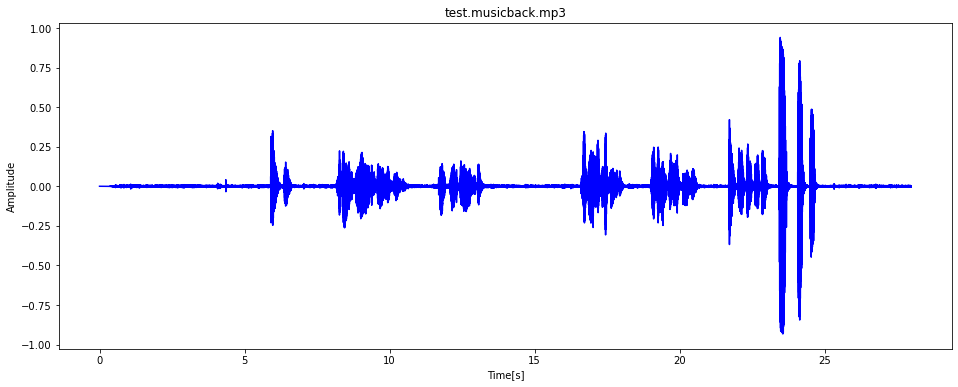

file_dir: ../../tracks/track
file_id: test.musicback.mp3


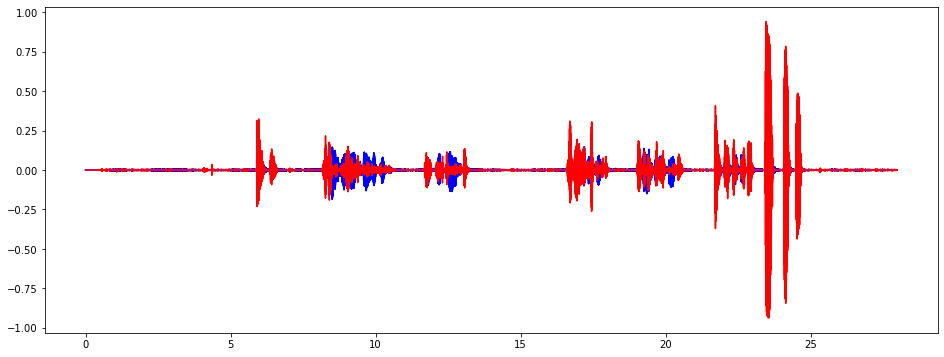

In [37]:
draw_amplitude(test_dir[0])
draw_har_per(test_dir[0])

In [48]:
pred_df[pred_df['name']=='test.musicback2'][:30]

,name,path,duration,start,end,y_pred
26,test.musicback2,../../tracks/splited_voice/test.musicback2/0_3...,3.0,0,3,life
27,test.musicback2,../../tracks/splited_voice/test.musicback2/1_4...,3.0,1,4,life
28,test.musicback2,../../tracks/splited_voice/test.musicback2/2_5...,3.0,2,5,life
29,test.musicback2,../../tracks/splited_voice/test.musicback2/3_6...,3.0,3,6,animal
30,test.musicback2,../../tracks/splited_voice/test.musicback2/4_7...,3.0,4,7,animal
31,test.musicback2,../../tracks/splited_voice/test.musicback2/5_8...,3.0,5,8,life
32,test.musicback2,../../tracks/splited_voice/test.musicback2/6_9...,3.0,6,9,life
33,test.musicback2,../../tracks/splited_voice/test.musicback2/7_1...,3.0,7,10,life
34,test.musicback2,../../tracks/splited_voice/test.musicback2/8_1...,3.0,8,11,life
35,test.musicback2,../../tracks/splited_voice/test.musicback2/9_1...,3.0,9,12,life


In [50]:
pred_df[pred_df['name']=='test.musicback2'][30:]

,name,path,duration,start,end,y_pred
56,test.musicback2,../../tracks/splited_voice/test.musicback2/30_...,3.000000,30,33,human_voice
57,test.musicback2,../../tracks/splited_voice/test.musicback2/31_...,3.000000,31,34,human_voice
58,test.musicback2,../../tracks/splited_voice/test.musicback2/32_...,3.000000,32,35,human_voice
59,test.musicback2,../../tracks/splited_voice/test.musicback2/33_...,3.000000,33,36,human_voice
60,test.musicback2,../../tracks/splited_voice/test.musicback2/34_...,3.000000,34,37,animal
61,test.musicback2,../../tracks/splited_voice/test.musicback2/35_...,3.000000,35,38,human_voice
62,test.musicback2,../../tracks/splited_voice/test.musicback2/36_...,3.000000,36,39,human_voice
63,test.musicback2,../../tracks/splited_voice/test.musicback2/37_...,3.000000,37,40,animal
64,test.musicback2,../../tracks/splited_voice/test.musicback2/38_...,3.000000,38,41,life
65,test.musicback2,../../tracks/splited_voice/test.musicback2/39_...,3.000000,39,42,life


file_dir: ../../tracks/track
file_id: test.musicback2.mp3


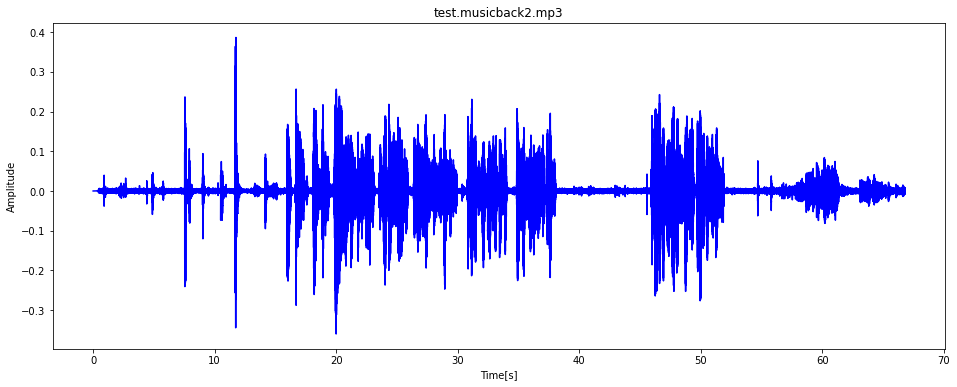

file_dir: ../../tracks/track
file_id: test.musicback2.mp3


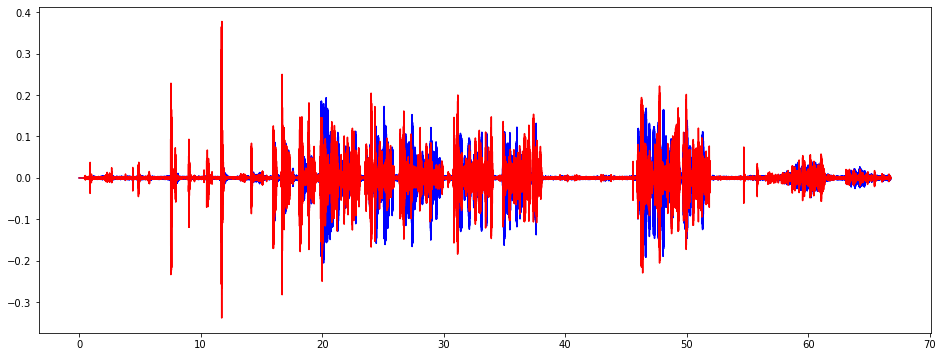

In [38]:
draw_amplitude(test_dir[1])
draw_har_per(test_dir[1])

In [13]:
pred_df[pred_df['y_pred']!='human_voice'].groupby(['name','y_pred','start']).count()

path  duration  end
name            y_pred start                     
test.musicback  human  3         1         1    1
                       4         1         1    1
                       5         1         1    1
                       13        1         1    1
                       14        1         1    1
                       20        1         1    1
                       21        1         1    1
                       22        1         1    1
                       23        1         1    1
                       24        1         1    1
test.musicback2 animal 3         1         1    1
                       10        1         1    1
                       12        1         1    1
                       40        1         1    1
                       57        1         1    1
                human  8         1         1    1
                       14        1         1    1
                       15        1         1    1
                       36        1         1    1
                       37        1         1    1
                       38        1         1    1
                       43        1         1    1
                       51        1         1    1
                       56        1         1    1
                       58        1         1    1
                       59        1         1    1
                       60        1         1    1
                       61        1         1    1
                       62        1         1    1
                       64        1         1    1
                life   0         1         1    1
                       1         1         1    1
                       6         1         1    1
                       7         1         1    1
                       9         1         1    1
                       11        1         1    1
                       13        1         1    1
                       39        1         1    1